# 11.1 Image stitching

Image stitching (Mosaicing) is considered as an active research area in computer vision and computer graphics. Image stitching is concerned with combining two or more images of the same scene into one high resolution image which is called panoramic image. The basic geometry of the problem is well understood, and consists of estimating a $3\times3$ camera matrix or homography for each image.

In this practise, we will explain how a complex image stitching application works and you will develop a basic one. You will need to understand how feature matching (chapter 04) and homographies (chapter 08) work in order to complete this notebook.

<img src="./images/stitching5_res.jpg" width="800" />

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)
images_path = './images/'

# OpenCV Stitcher class

OpenCV defines the class [Stitcher](https://docs.opencv.org/4.2.0/d2/d8d/classcv_1_1Stitcher.html), which implements a complex image stitching tool. The next code shows an example of how two or more images can be stitched using that class:

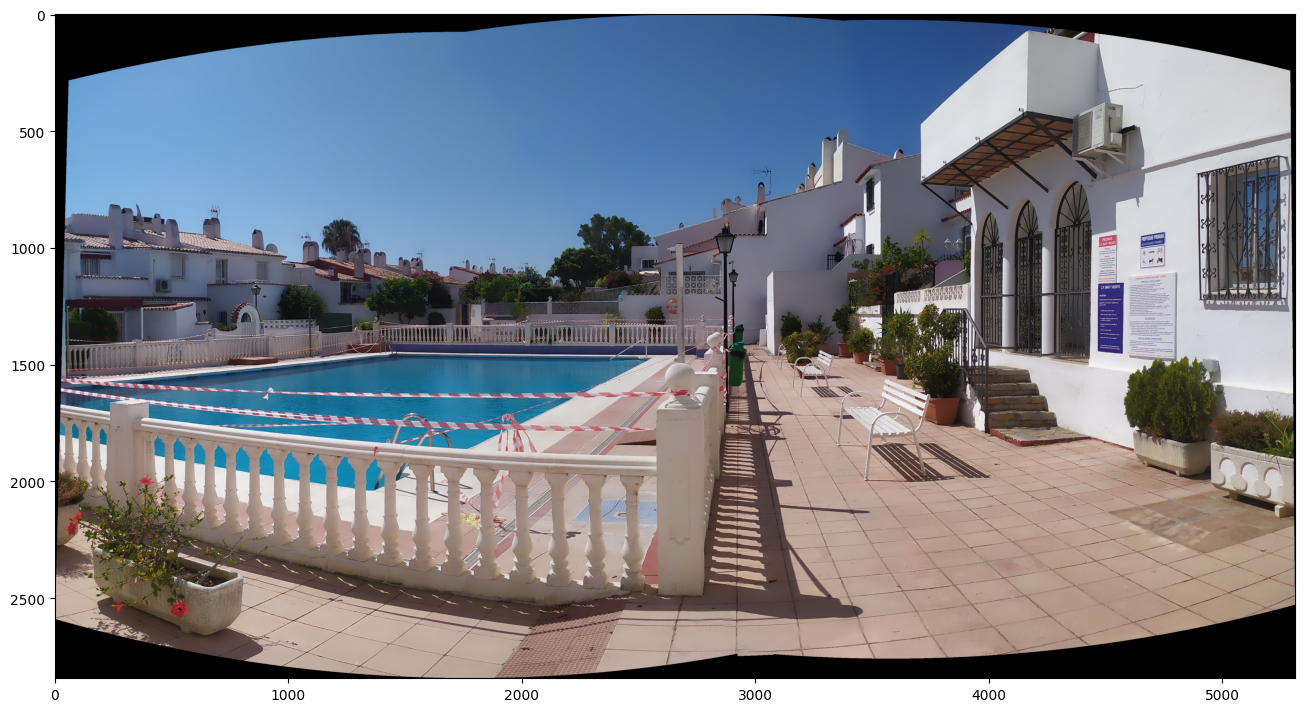

In [2]:
images = []
images.append(cv2.imread("./images/stitching2_1.jpg"))
images.append(cv2.imread("./images/stitching2_2.jpg"))
images.append(cv2.imread("./images/stitching2_3.jpg"))

stitcher = cv2.Stitcher.create(mode=0)
_, panorama = stitcher.stitch(images)

cv2.imwrite("./images/stitching2_res.jpg",panorama)
panorama = cv2.cvtColor(panorama,cv2.COLOR_BGR2RGB)
plt.imshow(panorama)

But... **how does it works?**

Basically, for achieving image stitching, we have 2 main steps:

- **Finding and matchign features.** The first step in panorama stitching is to extract and match features. For this we can use Harris + NCC, ORB, ...

- **Image Matching.**  In this step, we can use [RANSAC, LMEDS, ...](https://docs.opencv.org/4.2.0/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780) methods to estimate the Homographies of the best matched pairs, with these homographies, images can be aligned. And images aligned this way is called **local registration**.

However, we can enhance resulting images using some extra methods that complex tools usually implement. We can see the whole stitching module pipeline that is implemented in openCV in the following figure:

<img src="./images/pipeline.png" width="800" />

Using the Stitcher class, it's possible to configure/remove some steps, i.e. adjust the stitching pipeline according to the particular needs. You can get information about extra steps for a complete image stitching tool [here](https://sites.google.com/site/ritpanoramaapp/project-stage-iii).

**Your task in this notebook** is to stitch example images `stitching_1.jpg` and `stitching_2.jpg`. You can see how openCV achieve it using the following code:

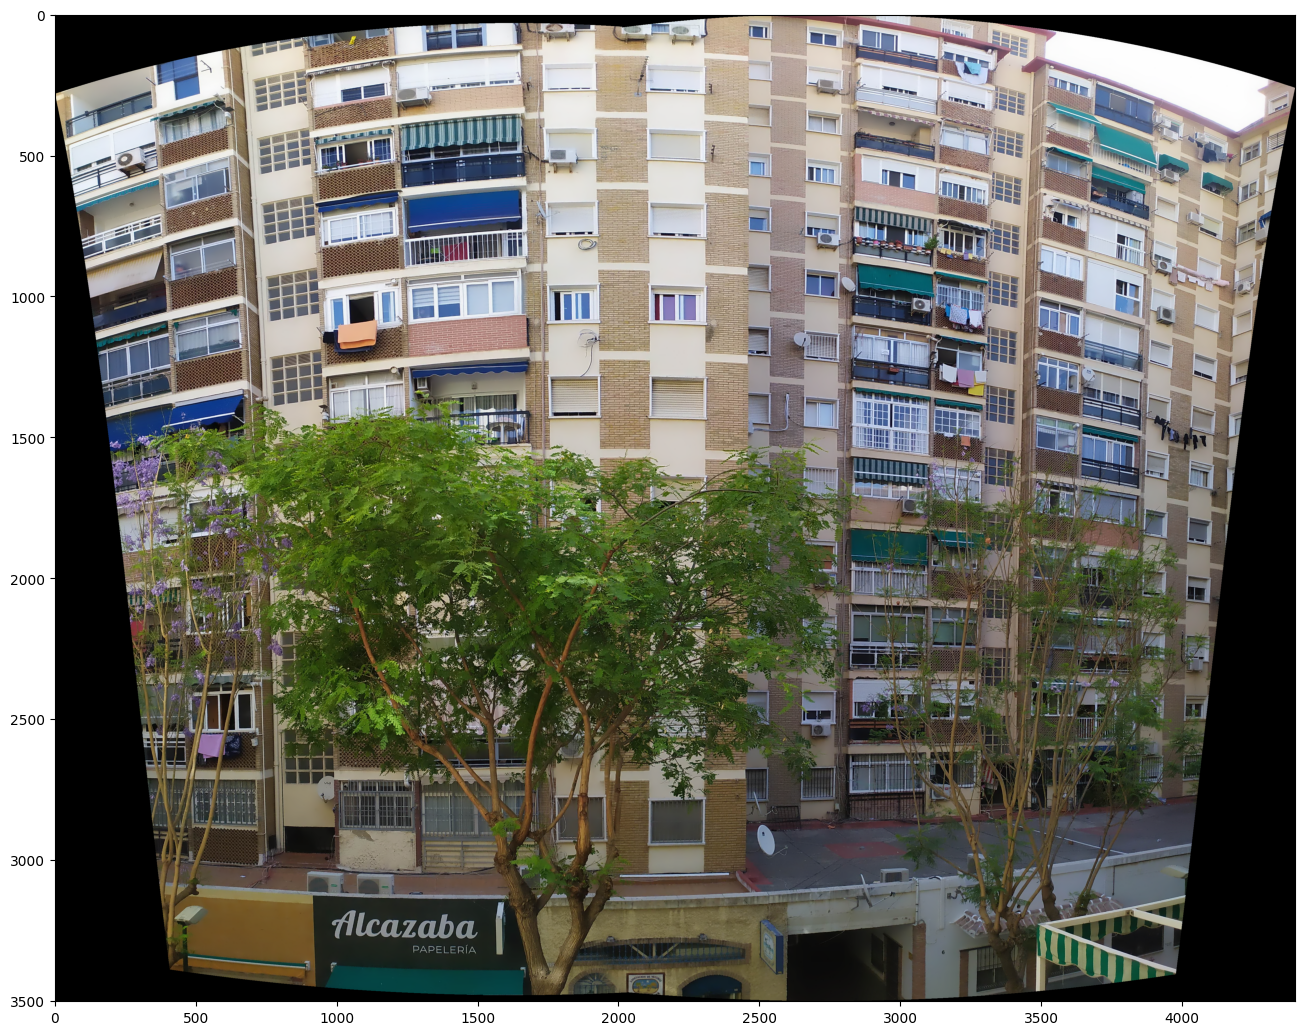

In [3]:
images = []
images.append(cv2.imread("./images/stitching_1.jpg"))
images.append(cv2.imread("./images/stitching_2.jpg"))


stitcher = cv2.Stitcher.create(mode=0)
_, panorama = stitcher.stitch(images)

cv2.imwrite("./images/stitching_res.jpg",panorama)
panorama = cv2.cvtColor(panorama,cv2.COLOR_BGR2RGB)
plt.imshow(panorama)

### <span style="color:green"><b><i>ASSIGNMENT 1: Developing our own stitcher</i></b></span>

As we said above, we have to stitch images `stitching_1.jpg` and `stitching_2.jpg` with our own code, avoiding the class `cv2.Stitcher` in order to learn how it can be done from scratch.

In a nutshell, what you should do is **finding matching points in both images** and then **finding the homography that transforms the points in the second image over their matchings in the first one**, or the other way around (you may use `cv2.RANSAC` for finding the homography). Resulting image should look like this (as you can see, only the second image has been transformed):

<img src="./images/stitching_manual.png" width="600" />

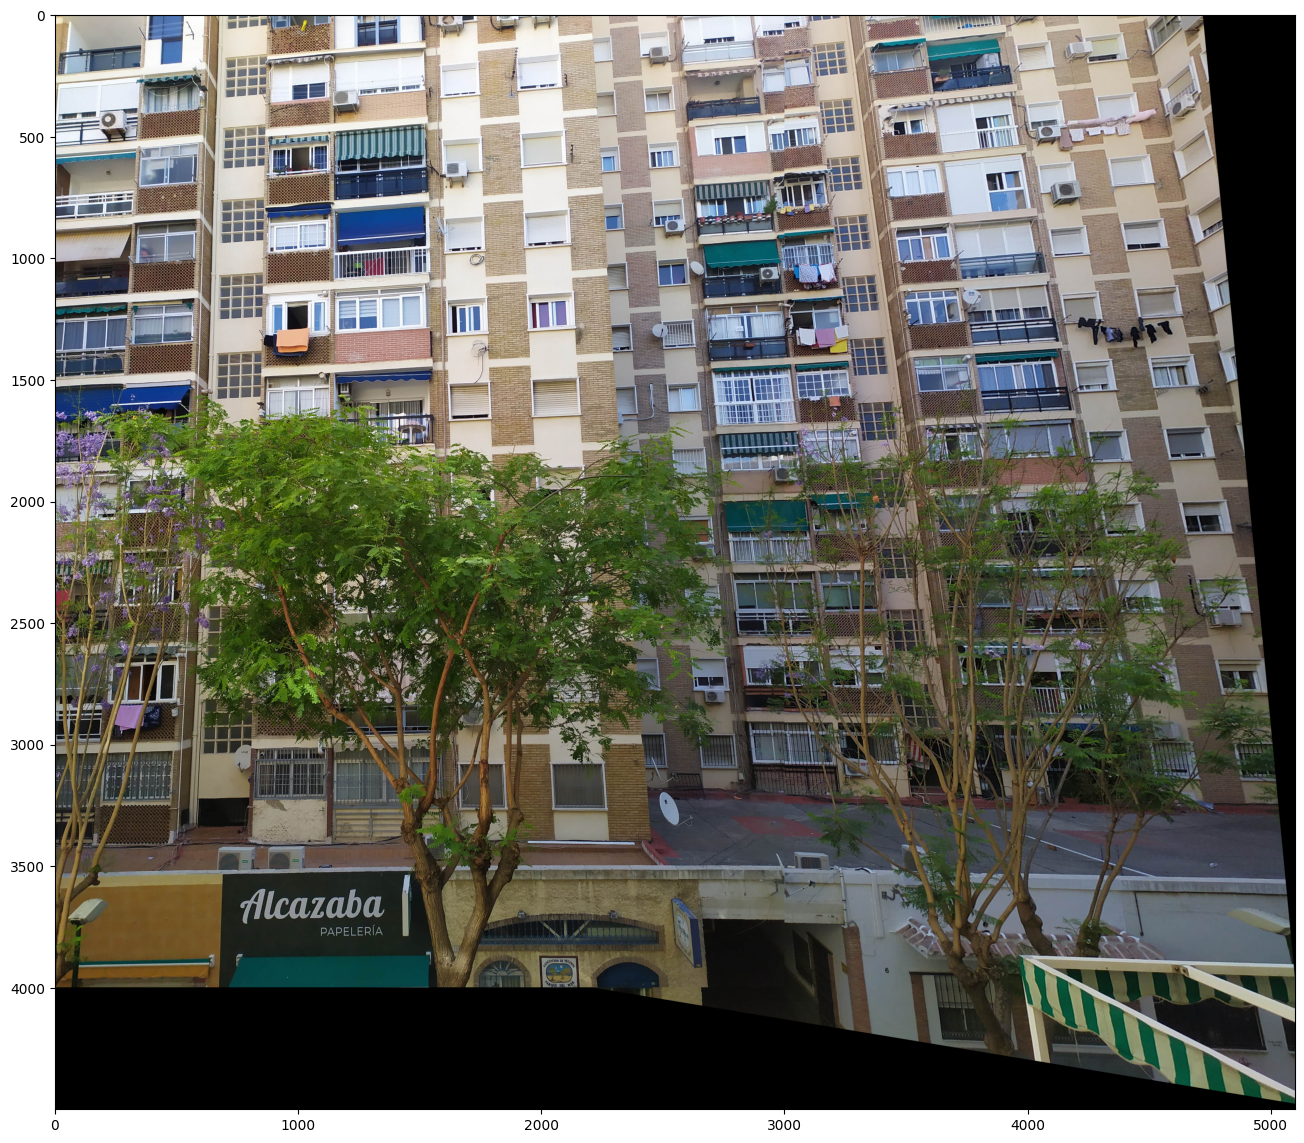

In [4]:
# Read first image
im_1 = cv2.imread(images_path + "stitching_1.jpg") #queryimage
im_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2RGB)

# Read segond image
im_2 = cv2.imread(images_path + "stitching_2.jpg")  #trainimage
im_2 = cv2.cvtColor(im_2, cv2.COLOR_BGR2RGB)

# Get gray images
gray_1 = cv2.cvtColor(im_1,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(im_2,cv2.COLOR_RGB2GRAY)

# Detect the ORB keypoints using the OpenCV method
# -- create the ORB detector
orb = cv2.ORB_create()

# -- detect ORB keypoints 
kp_1 = orb.detect(gray_1,None)
kp_2 = orb.detect(gray_2,None)

# -- compute the descriptors with ORB
kp_1, des_1 = orb.compute(gray_1, kp_1)
kp_2, des_2 = orb.compute(gray_2, kp_2)

# Match descriptors.
matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(des_1,des_2)

# Create lists of corresponding keypoints
pts_1 = []
pts_2 = []
for match in matches:
    pts_1.append(kp_1[match.queryIdx].pt)
    pts_2.append(kp_2[match.trainIdx].pt)
    
pts_1 = np.float32(pts_1)
pts_2 = np.float32(pts_2)
    
# Calculate Homography
M, status = cv2.findHomography(pts_2, pts_1, cv2.RANSAC)

stitched = cv2.warpPerspective(im_2, M, (5100,4500))
stitched[:im_1.shape[0],:im_1.shape[1]] = im_1

plt.imshow(stitched)